In [1]:
# ========== INSTALL EVERYTHING IN-KERNEL ==========
!pip install -q ffmpeg-python imageio[ffmpeg] pims opencv-python-headless torch torchvision argcomplete autopep8 engineering_notation easygui screeninfo dv_processing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.7/92.7 kB 5.5 MB/s eta 0:00:00
   ━━

In [2]:
!pip install dv_processing

# CODE TO EXTRACT THE DVS VEDIOS FROM THE GOPRO RGB IMAGES

In [3]:
# ============================
# 1) INSTALL dependencies
# ============================
!pip install -q \
    ffmpeg-python imageio[ffmpeg] pims \
    opencv-python-headless torch torchvision \
    tqdm numpy pillow requests gdown

# ============================
# 2) CLONE & INSTALL v2e
# ============================
import os, shutil, subprocess

WORKING_DIR = "/kaggle/working"
V2E_DIR     = os.path.join(WORKING_DIR, "v2e")

if os.path.isdir(V2E_DIR):
    shutil.rmtree(V2E_DIR)

subprocess.run(f"git clone https://github.com/SensorsINI/v2e.git {V2E_DIR}", 
               shell=True, check=True)
subprocess.run(f"pip install -q -e {V2E_DIR}", shell=True, check=True)

# ============================
# 3) DOWNLOAD SuperSloMo checkpoint
# ============================
DRIVE_ID   = "1ETID_4xqLpRBrRo1aOT7Yphs3QqWR_fx"   # correct file ID
CKPT_LOCAL = os.path.join(WORKING_DIR, "SuperSloMo39.ckpt")
MODEL_DIR  = os.path.join(V2E_DIR, "v2e_networks")
MODEL_PATH = os.path.join(MODEL_DIR, "SuperSloMo39.pth.tar")

if not os.path.isfile(CKPT_LOCAL):
    print("⬇️ Downloading SuperSloMo39.ckpt…")
    subprocess.run(f"gdown --id {DRIVE_ID} -O {CKPT_LOCAL}", shell=True, check=True)
    print("✅ Downloaded ckpt to:", CKPT_LOCAL)

os.makedirs(MODEL_DIR, exist_ok=True)
shutil.move(CKPT_LOCAL, MODEL_PATH)
print("✅ Model moved to:", MODEL_PATH)

# ============================
# 4) LOAD LABELS
# ============================
import pandas as pd

RGB_ROOT = '/kaggle/input/nefer-data/rgb_frames'
CSV_PATH = '/kaggle/input/nefer-data/annotations/reported_emotions/train_gopro_subjective.csv'
OUTPUT_ROOT = os.path.join(WORKING_DIR, "v2e_output")
OUTPUT_CSV  = os.path.join(WORKING_DIR, "v2e_event_labels.csv")
FRAME_RATE  = 60

df = pd.read_csv(CSV_PATH)
df.columns = df.columns.str.strip()
df = df.rename(columns={df.columns[0]:"user", df.columns[1]:"session", df.columns[3]:"label"})
df["user"]    = df["user"].str.strip()
df["session"] = df["session"].str.strip()
df["label"]   = df["label"].str.strip().str.lower()

session_labels = (
    df
    .drop_duplicates(subset=["user","session"])
    .set_index(["user","session"])["label"]
    .to_dict()
)

# ============================
# 5) BATCH PROCESS (skip user_00)
# ============================
records, total = [], 0
import subprocess

for user in sorted(os.listdir(RGB_ROOT)):
    if user == "user_00":
        print(f"⏭️ Skipping {user}")
        continue
    udir = os.path.join(RGB_ROOT, user)
    if not os.path.isdir(udir):
        continue

    for session in sorted(os.listdir(udir)):
        sdir = os.path.join(udir, session)
        if not os.path.isdir(sdir):
            continue

        pngs = [f for f in os.listdir(sdir) if f.endswith(".png")]
        if len(pngs) < 2:
            print(f"⚠️ Skipping {user}/{session} (<2 frames)")
            continue

        out_dir = os.path.join(OUTPUT_ROOT, user, session)
        os.makedirs(out_dir, exist_ok=True)
        label = session_labels.get((user,session), "unknown")

        print(f"🚀 Processing {user}/{session} → {label}")
        cmd = (
            f'cd "{V2E_DIR}" && python v2e.py '
            f'-i "{sdir}" -o "{out_dir}" '
            f'--slomo_model "{MODEL_PATH}" '
            f'--input_frame_rate {FRAME_RATE} '
            f'--dvs_exposure duration 0.01 '
            f'--cutoff_hz 300 '
            f'--overwrite '
            f'--no_preview '
            f'--disable_slomo'
        )
        try:
            subprocess.run(cmd, shell=True, check=True)
            records.append({
                "user": user,
                "session": session,
                "label": label,
                "dvs_output_folder": out_dir
            })
            total += 1
        except subprocess.CalledProcessError as e:
            print(f"❌ Failed: {user}/{session} — exit code {e.returncode}")

# ============================
# 6) SAVE SUMMARY CSV
# ============================
pd.DataFrame(records).to_csv(OUTPUT_CSV, index=False)
print(f"\n✅ Done. Total processed (excl. user_00): {total}")
print(f"📄 Labels CSV: {OUTPUT_CSV}")


Cloning into '/kaggle/working/v2e'...


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.3/142.3 kB 6.3 MB/s eta 0:00:00
⬇️ Downloading SuperSloMo39.ckpt…


/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1ETID_4xqLpRBrRo1aOT7Yphs3QqWR_fx
From (redirected): https://drive.google.com/uc?id=1ETID_4xqLpRBrRo1aOT7Yphs3QqWR_fx&confirm=t&uuid=6ae5cb06-5cec-4327-81c2-90d1cf4fdd75
To: /kaggle/working/SuperSloMo39.ckpt
100%|██████████| 158M/158M [00:03<00:00, 40.6MB/s] 


✅ Downloaded ckpt to: /kaggle/working/SuperSloMo39.ckpt
✅ Model moved to: /kaggle/working/v2e/v2e_networks/SuperSloMo39.pth.tar
⏭️ Skipping user_00
🚀 Processing user_01/GOPR0762 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 35.47fr/s]
npy2png: 51fr [00:00, 156.81fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 10.38fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_01/GOPR0763 → fear


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 32.38fr/s]
npy2png: 51fr [00:00, 157.26fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.02fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_01/GOPR0764 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 42.11fr/s]
npy2png: 51fr [00:00, 156.56fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 10.99fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_01/GOPR0765 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 43.82fr/s]
npy2png: 51fr [00:00, 155.73fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.00fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_01/GOPR0766 → nan


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 44.20fr/s]
npy2png: 51fr [00:00, 153.05fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 10.86fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_01/GOPR0767 → anger


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 49.18fr/s]
npy2png: 51fr [00:00, 155.45fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.11fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_01/GOPR0768 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 39.98fr/s]
npy2png: 51fr [00:00, 154.17fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 10.55fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_01/GOPR0769 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 41.15fr/s]
npy2png: 51fr [00:00, 156.54fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 10.78fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_01/GOPR0770 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 40.49fr/s]
npy2png: 51fr [00:00, 156.96fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.50fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_01/GOPR0771 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.47fr/s]
npy2png: 51fr [00:00, 152.36fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 10.76fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_01/GOPR0772 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.80fr/s]
npy2png: 51fr [00:00, 155.90fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.10fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_01/GOPR0773 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 37.97fr/s]
npy2png: 51fr [00:00, 156.31fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 10.73fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_01/GOPR0774 → fear


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 39.74fr/s]
npy2png: 51fr [00:00, 154.67fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.03fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_01/GOPR0775 → contempt


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 44.86fr/s]
npy2png: 51fr [00:00, 156.26fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.15fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_01/GOPR0776 → contempt


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 38.10fr/s]
npy2png: 51fr [00:00, 153.36fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.00fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_01/GOPR0777 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.63fr/s]
npy2png: 51fr [00:00, 155.30fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 10.90fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_01/GOPR0778 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 38.82fr/s]
npy2png: 51fr [00:00, 156.05fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 10.76fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_01/GOPR0779 → anger


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 37.35fr/s]
npy2png: 51fr [00:00, 153.48fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.12fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_01/GOPR0780 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.07fr/s]
npy2png: 51fr [00:00, 152.64fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 10.82fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_01/GOPR0781 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 41.65fr/s]
npy2png: 51fr [00:00, 157.72fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.83fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_01/GOPR0782 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 35.21fr/s]
npy2png: 51fr [00:00, 153.38fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.22fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_02/GOPR0783 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.55fr/s]
npy2png: 51fr [00:00, 158.03fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.06fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_02/GOPR0784 → fear


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.86fr/s]
npy2png: 51fr [00:00, 162.27fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 10.72fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_02/GOPR0785 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 41.99fr/s]
npy2png: 51fr [00:00, 163.75fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.94fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_02/GOPR0786 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.05fr/s]
npy2png: 51fr [00:00, 160.44fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.38fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_02/GOPR0787 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 40.89fr/s]
npy2png: 51fr [00:00, 165.31fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.68fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_02/GOPR0788 → anger


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.50fr/s]
npy2png: 51fr [00:00, 154.17fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.62fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_02/GOPR0789 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:02<00:00, 23.20fr/s]
npy2png: 51fr [00:00, 165.92fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.28fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_02/GOPR0790 → contempt


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.03fr/s]
npy2png: 51fr [00:00, 166.43fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.45fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_02/GOPR0791 → anger


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 43.89fr/s]
npy2png: 51fr [00:00, 165.25fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.34fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_02/GOPR0792 → anger


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 44.05fr/s]
npy2png: 51fr [00:00, 164.72fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.54fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_02/GOPR0793 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.31fr/s]
npy2png: 51fr [00:00, 165.78fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.46fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_02/GOPR0794 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.75fr/s]
npy2png: 51fr [00:00, 165.51fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.36fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_02/GOPR0795 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 30.48fr/s]
npy2png: 51fr [00:00, 165.26fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.49fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_02/GOPR0796 → contempt


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:02<00:00, 19.55fr/s]
npy2png: 51fr [00:00, 159.80fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.29fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_02/GOPR0797 → contempt


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 49.74fr/s]
npy2png: 51fr [00:00, 160.75fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.33fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_02/GOPR0798 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.14fr/s]
npy2png: 51fr [00:00, 163.24fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.09fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_02/GOPR0799 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 41.14fr/s]
npy2png: 51fr [00:00, 165.87fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.55fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_02/GOPR0800 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 50.54fr/s]
npy2png: 51fr [00:00, 166.07fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.66fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_02/GOPR0801 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.21fr/s]
npy2png: 51fr [00:00, 162.01fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.60fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_02/GOPR0802 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.25fr/s]
npy2png: 51fr [00:00, 165.66fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.47fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_02/GOPR0803 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.48fr/s]
npy2png: 51fr [00:00, 166.53fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.28fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_03/GOPR0804 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.93fr/s]
npy2png: 51fr [00:00, 171.04fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.10fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_03/GOPR0805 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.70fr/s]
npy2png: 51fr [00:00, 172.03fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 10.77fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_03/GOPR0806 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 44.36fr/s]
npy2png: 51fr [00:00, 173.66fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.03fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_03/GOPR0807 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.35fr/s]
npy2png: 51fr [00:00, 173.10fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.61fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_03/GOPR0808 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.57fr/s]
npy2png: 51fr [00:00, 172.77fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.52fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_03/GOPR0809 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 41.29fr/s]
npy2png: 51fr [00:00, 173.21fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.35fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_03/GOPR0810 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.51fr/s]
npy2png: 51fr [00:00, 172.90fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.62fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_03/GOPR0811 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.04fr/s]
npy2png: 51fr [00:00, 175.08fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.55fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_03/GOPR0812 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 43.59fr/s]
npy2png: 51fr [00:00, 171.32fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.55fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_03/GOPR0815 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 41.48fr/s]
npy2png: 51fr [00:00, 172.07fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.47fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_03/GOPR0816 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.08fr/s]
npy2png: 51fr [00:00, 173.61fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 10.96fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_03/GOPR0817 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 39.26fr/s]
npy2png: 51fr [00:00, 172.46fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.58fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_03/GOPR0818 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.64fr/s]
npy2png: 51fr [00:00, 172.55fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.28fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_03/GOPR0819 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 42.45fr/s]
npy2png: 51fr [00:00, 171.29fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.55fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_03/GOPR0820 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.74fr/s]
npy2png: 51fr [00:00, 171.89fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.14fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_03/GOPR0821 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.49fr/s]
npy2png: 51fr [00:00, 169.03fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.64fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_03/GOPR0822 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.65fr/s]
npy2png: 51fr [00:00, 169.12fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 10.93fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_03/GOPR0823 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:02<00:00, 24.69fr/s]
npy2png: 51fr [00:00, 168.74fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.27fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_03/GOPR0824 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 44.41fr/s]
npy2png: 51fr [00:00, 176.13fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 10.81fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_03/GOPR0825 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 49.23fr/s]
npy2png: 51fr [00:00, 169.94fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.02fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_04/GOPR0826 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 44.55fr/s]
npy2png: 51fr [00:00, 168.86fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.83fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_04/GOPR0827 → fear


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 42.73fr/s]
npy2png: 51fr [00:00, 164.89fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.52fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_04/GOPR0828 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.80fr/s]
npy2png: 51fr [00:00, 167.84fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 10.99fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_04/GOPR0829 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.53fr/s]
npy2png: 51fr [00:00, 166.42fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.63fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_04/GOPR0830 → nan


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.29fr/s]
npy2png: 51fr [00:00, 168.60fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.14fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_04/GOPR0831 → contempt


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 40.90fr/s]
npy2png: 51fr [00:00, 168.97fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.44fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_04/GOPR0832 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.83fr/s]
npy2png: 51fr [00:00, 168.73fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.29fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_04/GOPR0833 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.43fr/s]
npy2png: 51fr [00:00, 171.09fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.38fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_04/GOPR0834 → anger


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 43.83fr/s]
npy2png: 51fr [00:00, 171.19fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.22fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_04/GOPR0835 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.32fr/s]
npy2png: 51fr [00:00, 169.82fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.31fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_04/GOPR0836 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.17fr/s]
npy2png: 51fr [00:00, 163.95fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.48fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_04/GOPR0837 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 50.16fr/s]
npy2png: 51fr [00:00, 171.51fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.09fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_04/GOPR0838 → fear


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.31fr/s]
npy2png: 51fr [00:00, 170.81fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.18fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_04/GOPR0839 → contempt


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.38fr/s]
npy2png: 51fr [00:00, 168.99fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.36fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_04/GOPR0840 → contempt


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.84fr/s]
npy2png: 51fr [00:00, 166.94fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 10.82fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_04/GOPR0841 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.73fr/s]
npy2png: 51fr [00:00, 169.44fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.57fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_04/GOPR0842 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.93fr/s]
npy2png: 51fr [00:00, 147.78fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 10.72fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_04/GOPR0843 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.36fr/s]
npy2png: 51fr [00:00, 171.21fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.31fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_04/GOPR0844 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.13fr/s]
npy2png: 51fr [00:00, 151.84fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.21fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_04/GOPR0845 → fear


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.77fr/s]
npy2png: 51fr [00:00, 172.36fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.43fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_04/GOPR0846 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.76fr/s]
npy2png: 51fr [00:00, 171.76fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.07fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_05/GOPR0847 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 40.20fr/s]
npy2png: 51fr [00:00, 161.47fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.00fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_05/GOPR0848 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 43.07fr/s]
npy2png: 51fr [00:00, 149.21fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.80fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_05/GOPR0849 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 42.57fr/s]
npy2png: 51fr [00:00, 156.38fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.01fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_05/GOPR0851 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 40.67fr/s]
npy2png: 51fr [00:00, 147.69fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.01fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_05/GOPR0852 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.68fr/s]
npy2png: 51fr [00:00, 164.73fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.40fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_05/GOPR0853 → anger


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 39.98fr/s]
npy2png: 51fr [00:00, 156.69fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.34fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_05/GOPR0854 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.03fr/s]
npy2png: 51fr [00:00, 163.94fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 10.82fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_05/GOPR0855 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 40.68fr/s]
npy2png: 51fr [00:00, 153.84fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 12.08fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_05/GOPR0856 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.76fr/s]
npy2png: 51fr [00:00, 164.93fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.32fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_05/GOPR0857 → anger


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 40.28fr/s]
npy2png: 51fr [00:00, 164.57fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.41fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_05/GOPR0858 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 41.39fr/s]
npy2png: 51fr [00:00, 165.79fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.22fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_05/GOPR0859 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.11fr/s]
npy2png: 51fr [00:00, 163.82fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 10.74fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_05/GOPR0860 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 36.82fr/s]
npy2png: 51fr [00:00, 164.05fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 10.86fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_05/GOPR0861 → contempt


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 38.96fr/s]
npy2png: 51fr [00:00, 164.81fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 10.53fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_05/GOPR0862 → anger


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 40.25fr/s]
npy2png: 51fr [00:00, 161.92fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.30fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_05/GOPR0863 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 38.95fr/s]
npy2png: 51fr [00:00, 160.03fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 10.86fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_05/GOPR0864 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 44.72fr/s]
npy2png: 51fr [00:00, 161.02fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 10.96fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_05/GOPR0865 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 43.42fr/s]
npy2png: 51fr [00:00, 165.93fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.21fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_05/GOPR0866 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 42.70fr/s]
npy2png: 51fr [00:00, 166.62fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 10.91fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_05/GOPR0867 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 42.31fr/s]
npy2png: 51fr [00:00, 164.72fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.10fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_05/GOPR0868 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 41.17fr/s]
npy2png: 51fr [00:00, 165.50fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.14fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_06/GOPR0869 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 38.62fr/s]
npy2png: 51fr [00:00, 161.89fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.40fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_06/GOPR0870 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.40fr/s]
npy2png: 51fr [00:00, 161.37fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.64fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_06/GOPR0871 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.51fr/s]
npy2png: 51fr [00:00, 158.81fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.36fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_06/GOPR0872 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 44.39fr/s]
npy2png: 51fr [00:00, 160.47fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.54fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_06/GOPR0873 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 44.47fr/s]
npy2png: 51fr [00:00, 163.50fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.53fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_06/GOPR0874 → anger


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.30fr/s]
npy2png: 51fr [00:00, 161.47fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.57fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_06/GOPR0875 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.03fr/s]
npy2png: 51fr [00:00, 163.11fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.55fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_06/GOPR0876 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 44.79fr/s]
npy2png: 51fr [00:00, 159.58fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.88fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_06/GOPR0877 → contempt


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 38.01fr/s]
npy2png: 51fr [00:00, 160.33fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.50fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_06/GOPR0878 → contempt


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 44.41fr/s]
npy2png: 51fr [00:00, 159.52fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.35fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_06/GOPR0879 → nan


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.13fr/s]
npy2png: 51fr [00:00, 146.66fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.66fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_06/GOPR0880 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 42.95fr/s]
npy2png: 51fr [00:00, 159.03fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.45fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_06/GOPR0881 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 43.86fr/s]
npy2png: 51fr [00:00, 157.70fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.38fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_06/GOPR0882 → contempt


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.03fr/s]
npy2png: 51fr [00:00, 152.42fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.04fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_06/GOPR0883 → contempt


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 41.00fr/s]
npy2png: 51fr [00:00, 160.61fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.31fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_06/GOPR0884 → contempt


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.28fr/s]
npy2png: 51fr [00:00, 164.67fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.25fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_06/GOPR0885 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 43.67fr/s]
npy2png: 51fr [00:00, 165.75fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.33fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_06/GOPR0886 → anger


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.77fr/s]
npy2png: 51fr [00:00, 165.61fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.47fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_06/GOPR0887 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.34fr/s]
npy2png: 51fr [00:00, 158.42fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.48fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_06/GOPR0888 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.59fr/s]
npy2png: 51fr [00:00, 167.65fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.39fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_06/GOPR0889 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.48fr/s]
npy2png: 51fr [00:00, 160.98fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.50fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_07/GOPR0890 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.30fr/s]
npy2png: 51fr [00:00, 160.91fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.21fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_07/GOPR0891 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 41.28fr/s]
npy2png: 51fr [00:00, 158.83fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.00fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_07/GOPR0892 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 44.26fr/s]
npy2png: 51fr [00:00, 166.87fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.00fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_07/GOPR0893 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 43.34fr/s]
npy2png: 51fr [00:00, 164.32fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 10.96fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_07/GOPR0894 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 42.48fr/s]
npy2png: 51fr [00:00, 157.09fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.67fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_07/GOPR0895 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 37.56fr/s]
npy2png: 51fr [00:00, 162.77fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.11fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_07/GOPR0896 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 40.65fr/s]
npy2png: 51fr [00:00, 162.52fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.16fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_07/GOPR0897 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 44.46fr/s]
npy2png: 51fr [00:00, 153.87fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.39fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_07/GOPR0898 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 43.08fr/s]
npy2png: 51fr [00:00, 159.48fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.15fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_07/GOPR0899 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.00fr/s]
npy2png: 51fr [00:00, 157.07fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.57fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_07/GOPR0900 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 42.06fr/s]
npy2png: 51fr [00:00, 157.74fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.14fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_07/GOPR0901 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 40.41fr/s]
npy2png: 51fr [00:00, 158.71fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.22fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_07/GOPR0902 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 41.97fr/s]
npy2png: 51fr [00:00, 157.79fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 10.95fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_07/GOPR0903 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 41.99fr/s]
npy2png: 51fr [00:00, 157.53fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.38fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_07/GOPR0904 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 43.37fr/s]
npy2png: 51fr [00:00, 159.00fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.01fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_07/GOPR0905 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.99fr/s]
npy2png: 51fr [00:00, 158.56fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.23fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_07/GOPR0906 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 41.92fr/s]
npy2png: 51fr [00:00, 159.65fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.36fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_07/GOPR0907 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 43.48fr/s]
npy2png: 51fr [00:00, 158.28fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.30fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_07/GOPR0908 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 41.92fr/s]
npy2png: 51fr [00:00, 158.49fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.05fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_07/GOPR0909 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 41.89fr/s]
npy2png: 51fr [00:00, 159.52fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 12.01fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_07/GOPR0910 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.42fr/s]
npy2png: 51fr [00:00, 159.46fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 10.87fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_08/GOPR0911 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.72fr/s]
npy2png: 51fr [00:00, 169.20fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.67fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_08/GOPR0915 → fear


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:00<00:00, 51.11fr/s]
npy2png: 51fr [00:00, 168.41fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.14fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_08/GOPR0916 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.09fr/s]
npy2png: 51fr [00:00, 167.39fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.51fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_08/GOPR0917 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.04fr/s]
npy2png: 51fr [00:00, 164.81fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 10.99fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_08/GOPR0918 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.42fr/s]
npy2png: 51fr [00:00, 164.86fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.23fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_08/GOPR0919 → anger


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 50.77fr/s]
npy2png: 51fr [00:00, 168.08fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.01fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_08/GOPR0920 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 42.27fr/s]
npy2png: 51fr [00:00, 167.33fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.23fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_08/GOPR0921 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 43.68fr/s]
npy2png: 51fr [00:00, 169.99fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.07fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_08/GOPR0922 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 50.29fr/s]
npy2png: 51fr [00:00, 161.77fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.75fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_08/GOPR0923 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:00<00:00, 51.04fr/s]
npy2png: 51fr [00:00, 170.16fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.61fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_08/GOPR0924 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.52fr/s]
npy2png: 51fr [00:00, 169.91fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.65fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_08/GOPR0925 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.18fr/s]
npy2png: 51fr [00:00, 168.34fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.29fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_08/GOPR0926 → fear


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 50.84fr/s]
npy2png: 51fr [00:00, 169.30fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.44fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_08/GOPR0927 → contempt


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 50.15fr/s]
npy2png: 51fr [00:00, 167.06fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.45fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_08/GOPR0928 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.83fr/s]
npy2png: 51fr [00:00, 172.04fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.79fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_08/GOPR0929 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.75fr/s]
npy2png: 51fr [00:00, 171.18fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.65fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_08/GOPR0930 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.74fr/s]
npy2png: 51fr [00:00, 170.34fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.84fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_08/GOPR0931 → contempt


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:00<00:00, 51.45fr/s]
npy2png: 51fr [00:00, 171.92fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.51fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_08/GOPR0932 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.56fr/s]
npy2png: 51fr [00:00, 168.41fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.61fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_08/GOPR0933 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.46fr/s]
npy2png: 51fr [00:00, 168.43fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.55fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_08/GOPR0934 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:00<00:00, 52.51fr/s]
npy2png: 51fr [00:00, 169.98fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.43fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_09/GOPR0935 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.01fr/s]
npy2png: 51fr [00:00, 161.22fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.80fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_09/GOPR0936 → fear


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 44.23fr/s]
npy2png: 51fr [00:00, 159.70fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.23fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_09/GOPR0937 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 43.58fr/s]
npy2png: 51fr [00:00, 158.76fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.22fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_09/GOPR0938 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.34fr/s]
npy2png: 51fr [00:00, 162.38fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.73fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_09/GOPR0939 → nan


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.33fr/s]
npy2png: 51fr [00:00, 163.42fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.25fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_09/GOPR0940 → contempt


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 44.24fr/s]
npy2png: 51fr [00:00, 163.43fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.10fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_09/GOPR0941 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.01fr/s]
npy2png: 51fr [00:00, 152.95fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.42fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_09/GOPR0942 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 49.01fr/s]
npy2png: 51fr [00:00, 162.41fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.30fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_09/GOPR0943 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 42.01fr/s]
npy2png: 51fr [00:00, 148.03fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.58fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_09/GOPR0944 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 44.58fr/s]
npy2png: 51fr [00:00, 163.76fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.60fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_09/GOPR0945 → contempt


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 44.40fr/s]
npy2png: 51fr [00:00, 152.85fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.63fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_09/GOPR0946 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 49.21fr/s]
npy2png: 51fr [00:00, 162.22fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.49fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_09/GOPR0947 → fear


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 43.92fr/s]
npy2png: 51fr [00:00, 161.72fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.54fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_09/GOPR0948 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 44.55fr/s]
npy2png: 51fr [00:00, 166.69fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.73fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_09/GOPR0949 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.93fr/s]
npy2png: 51fr [00:00, 164.21fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.63fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_09/GOPR0950 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 49.54fr/s]
npy2png: 51fr [00:00, 163.55fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.64fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_09/GOPR0951 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 44.03fr/s]
npy2png: 51fr [00:00, 160.77fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.58fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_09/GOPR0952 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.38fr/s]
npy2png: 51fr [00:00, 166.08fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.84fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_09/GOPR0953 → nan


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 43.95fr/s]
npy2png: 51fr [00:00, 153.61fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.56fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_09/GOPR0954 → fear


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 50.55fr/s]
npy2png: 51fr [00:00, 166.74fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.59fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_09/GOPR0955 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 43.81fr/s]
npy2png: 51fr [00:00, 159.97fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.40fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_10/GOPR0956 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.00fr/s]
npy2png: 51fr [00:00, 162.63fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.80fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_10/GOPR0957 → fear


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.65fr/s]
npy2png: 51fr [00:00, 163.24fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.76fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_10/GOPR0958 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.14fr/s]
npy2png: 51fr [00:00, 163.69fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.55fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_10/GOPR0959 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 41.32fr/s]
npy2png: 51fr [00:00, 160.87fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.87fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_10/GOPR0960 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 44.61fr/s]
npy2png: 51fr [00:00, 166.36fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 12.22fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_10/GOPR0961 → contempt


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.04fr/s]
npy2png: 51fr [00:00, 148.67fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.66fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_10/GOPR0962 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 49.90fr/s]
npy2png: 51fr [00:00, 167.87fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.74fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_10/GOPR0963 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 44.77fr/s]
npy2png: 51fr [00:00, 157.43fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.36fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_10/GOPR0964 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.97fr/s]
npy2png: 51fr [00:00, 163.84fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.39fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_10/GOPR0965 → contempt


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.66fr/s]
npy2png: 51fr [00:00, 157.11fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.65fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_10/GOPR0966 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.11fr/s]
npy2png: 51fr [00:00, 166.43fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.71fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_10/GOPR0967 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.26fr/s]
npy2png: 51fr [00:00, 161.05fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.75fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_10/GOPR0968 → fear


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.54fr/s]
npy2png: 51fr [00:00, 164.48fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.65fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_10/GOPR0969 → contempt


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.73fr/s]
npy2png: 51fr [00:00, 155.31fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.42fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_10/GOPR0970 → contempt


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.91fr/s]
npy2png: 51fr [00:00, 158.49fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.50fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_10/GOPR0971 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 44.14fr/s]
npy2png: 51fr [00:00, 161.00fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.78fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_10/GOPR0972 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 49.55fr/s]
npy2png: 51fr [00:00, 162.08fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.61fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_10/GOPR0973 → contempt


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 49.38fr/s]
npy2png: 51fr [00:00, 157.91fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.64fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_10/GOPR0974 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 44.90fr/s]
npy2png: 51fr [00:00, 157.46fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.39fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_10/GOPR0975 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.99fr/s]
npy2png: 51fr [00:00, 161.22fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.69fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_10/GOPR0976 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 49.23fr/s]
npy2png: 51fr [00:00, 160.26fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.63fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_11/GOPR0977 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.28fr/s]
npy2png: 51fr [00:00, 145.02fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.72fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_11/GOPR0978 → fear


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 35.45fr/s]
npy2png: 51fr [00:00, 163.56fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.60fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_11/GOPR0979 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.75fr/s]
npy2png: 51fr [00:00, 165.04fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.22fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_11/GOPR0980 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.72fr/s]
npy2png: 51fr [00:00, 167.13fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.72fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_11/GOPR0981 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 43.59fr/s]
npy2png: 51fr [00:00, 167.01fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.64fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_11/GOPR0982 → contempt


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.08fr/s]
npy2png: 51fr [00:00, 167.57fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.53fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_11/GOPR0983 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 43.47fr/s]
npy2png: 51fr [00:00, 164.35fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.46fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_11/GOPR0984 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.09fr/s]
npy2png: 51fr [00:00, 163.97fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.33fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_11/GOPR0985 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 43.35fr/s]
npy2png: 51fr [00:00, 165.26fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.64fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_11/GOPR0986 → anger


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.98fr/s]
npy2png: 51fr [00:00, 167.26fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.58fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_11/GOPR0987 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 36.07fr/s]
npy2png: 51fr [00:00, 164.88fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.51fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_11/GOPR0988 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 30.62fr/s]
npy2png: 51fr [00:00, 161.89fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.13fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_11/GOPR0989 → fear


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 27.70fr/s]
npy2png: 51fr [00:00, 165.94fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.17fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_11/GOPR0990 → anger


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 41.36fr/s]
npy2png: 51fr [00:00, 165.36fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.46fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_11/GOPR0991 → contempt


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.77fr/s]
npy2png: 51fr [00:00, 161.51fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.64fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_11/GOPR0992 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.10fr/s]
npy2png: 51fr [00:00, 166.45fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.64fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_11/GOPR0993 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 44.50fr/s]
npy2png: 51fr [00:00, 165.57fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.40fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_11/GOPR0994 → contempt


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:02<00:00, 21.53fr/s]
npy2png: 51fr [00:00, 166.95fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.66fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_11/GOPR0995 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.06fr/s]
npy2png: 51fr [00:00, 166.11fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.42fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_11/GOPR0996 → fear


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 38.39fr/s]
npy2png: 51fr [00:00, 163.95fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.26fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_11/GOPR0997 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 44.09fr/s]
npy2png: 51fr [00:00, 165.37fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.63fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_12/GOPR0998 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.38fr/s]
npy2png: 51fr [00:00, 155.90fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.75fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_12/GOPR0999 → fear


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.19fr/s]
npy2png: 51fr [00:00, 164.22fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.22fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_12/GOPR1000 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.51fr/s]
npy2png: 51fr [00:00, 163.99fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.43fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_12/GOPR1001 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.07fr/s]
npy2png: 51fr [00:00, 162.84fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.29fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_12/GOPR1002 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.86fr/s]
npy2png: 51fr [00:00, 160.90fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.98fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_12/GOPR1003 → contempt


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 50.31fr/s]
npy2png: 51fr [00:00, 162.43fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.44fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_12/GOPR1004 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.62fr/s]
npy2png: 51fr [00:00, 159.84fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.32fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_12/GOPR1005 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.64fr/s]
npy2png: 51fr [00:00, 160.08fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.66fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_12/GOPR1006 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.05fr/s]
npy2png: 51fr [00:00, 157.90fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.72fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_12/GOPR1007 → anger


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 50.56fr/s]
npy2png: 51fr [00:00, 157.83fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.93fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_12/GOPR1008 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.22fr/s]
npy2png: 51fr [00:00, 154.95fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.80fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_12/GOPR1009 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.21fr/s]
npy2png: 51fr [00:00, 157.48fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.54fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_12/GOPR1010 → nan


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.88fr/s]
npy2png: 51fr [00:00, 160.13fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.64fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_12/GOPR1011 → contempt


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 44.92fr/s]
npy2png: 51fr [00:00, 162.54fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.79fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_12/GOPR1012 → contempt


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 42.79fr/s]
npy2png: 51fr [00:00, 158.89fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.73fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_12/GOPR1013 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.68fr/s]
npy2png: 51fr [00:00, 158.21fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.43fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_12/GOPR1014 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 49.08fr/s]
npy2png: 51fr [00:00, 160.37fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.88fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_12/GOPR1015 → anger


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 44.21fr/s]
npy2png: 51fr [00:00, 158.27fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.91fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_12/GOPR1016 → nan


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 44.57fr/s]
npy2png: 51fr [00:00, 155.22fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.64fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_12/GOPR1017 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.23fr/s]
npy2png: 51fr [00:00, 163.70fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.36fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_12/GOPR1018 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.01fr/s]
npy2png: 51fr [00:00, 160.78fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.07fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_13/GOPR1019 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 40.74fr/s]
npy2png: 51fr [00:00, 157.30fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.62fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_13/GOPR1020 → fear


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.75fr/s]
npy2png: 51fr [00:00, 157.07fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.48fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_13/GOPR1021 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.07fr/s]
npy2png: 51fr [00:00, 156.72fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.88fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_13/GOPR1022 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.58fr/s]
npy2png: 51fr [00:00, 155.05fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.80fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_13/GOPR1023 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 44.84fr/s]
npy2png: 51fr [00:00, 156.09fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.89fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_13/GOPR1024 → contempt


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.87fr/s]
npy2png: 51fr [00:00, 154.32fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.81fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_13/GOPR1025 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.70fr/s]
npy2png: 51fr [00:00, 157.23fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.91fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_13/GOPR1026 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.55fr/s]
npy2png: 51fr [00:00, 157.53fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 12.06fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_13/GOPR1027 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 42.23fr/s]
npy2png: 51fr [00:00, 156.76fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 12.49fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_13/GOPR1028 → contempt


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 43.93fr/s]
npy2png: 51fr [00:00, 157.83fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 12.04fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_13/GOPR1029 → nan


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.57fr/s]
npy2png: 51fr [00:00, 157.46fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.62fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_13/GOPR1030 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.79fr/s]
npy2png: 51fr [00:00, 157.28fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 12.00fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_13/GOPR1031 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 43.06fr/s]
npy2png: 51fr [00:00, 157.95fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.87fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_13/GOPR1032 → anger


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.17fr/s]
npy2png: 51fr [00:00, 156.42fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 12.02fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_13/GOPR1033 → contempt


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.09fr/s]
npy2png: 51fr [00:00, 157.51fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.68fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_13/GOPR1034 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.77fr/s]
npy2png: 51fr [00:00, 147.18fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 12.40fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_13/GOPR1035 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 41.01fr/s]
npy2png: 51fr [00:00, 156.49fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.87fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_13/GOPR1036 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 37.54fr/s]
npy2png: 51fr [00:00, 157.32fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.91fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_13/GOPR1037 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 43.48fr/s]
npy2png: 51fr [00:00, 157.93fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.96fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_13/GOPR1038 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 44.76fr/s]
npy2png: 51fr [00:00, 152.36fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.79fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_13/GOPR1039 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.68fr/s]
npy2png: 51fr [00:00, 156.00fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.49fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_14/GOPR1040 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.59fr/s]
npy2png: 51fr [00:00, 161.19fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.84fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_14/GOPR1041 → fear


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.24fr/s]
npy2png: 51fr [00:00, 160.78fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.07fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_14/GOPR1042 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.00fr/s]
npy2png: 51fr [00:00, 159.48fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.29fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_14/GOPR1043 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.72fr/s]
npy2png: 51fr [00:00, 160.74fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.69fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_14/GOPR1044 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.56fr/s]
npy2png: 51fr [00:00, 163.79fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 12.05fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_14/GOPR1045 → anger


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.53fr/s]
npy2png: 51fr [00:00, 162.63fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.79fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_14/GOPR1046 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.55fr/s]
npy2png: 51fr [00:00, 155.15fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.47fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_14/GOPR1047 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.48fr/s]
npy2png: 51fr [00:00, 161.22fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 12.05fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_14/GOPR1048 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.60fr/s]
npy2png: 51fr [00:00, 159.50fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.57fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_14/GOPR1049 → anger


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 49.64fr/s]
npy2png: 51fr [00:00, 161.03fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.65fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_14/GOPR1050 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.39fr/s]
npy2png: 51fr [00:00, 160.45fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.95fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_14/GOPR1051 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.46fr/s]
npy2png: 51fr [00:00, 162.24fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.63fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_14/GOPR1052 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.58fr/s]
npy2png: 51fr [00:00, 163.43fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.77fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_14/GOPR1053 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 44.74fr/s]
npy2png: 51fr [00:00, 164.03fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.77fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_14/GOPR1054 → contempt


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.24fr/s]
npy2png: 51fr [00:00, 160.47fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.87fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_14/GOPR1055 → nan


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.24fr/s]
npy2png: 51fr [00:00, 159.73fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.88fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_14/GOPR1056 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.66fr/s]
npy2png: 51fr [00:00, 161.13fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.99fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_14/GOPR1057 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 49.01fr/s]
npy2png: 51fr [00:00, 160.89fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.78fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_14/GOPR1058 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 43.64fr/s]
npy2png: 51fr [00:00, 159.84fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.72fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_14/GOPR1059 → fear


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.25fr/s]
npy2png: 51fr [00:00, 161.85fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.38fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_14/GOPR1061 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.55fr/s]
npy2png: 51fr [00:00, 163.11fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.70fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_15/GOPR1062 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.31fr/s]
npy2png: 51fr [00:00, 164.32fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 12.27fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_15/GOPR1063 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.86fr/s]
npy2png: 51fr [00:00, 164.69fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.65fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_15/GOPR1064 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.78fr/s]
npy2png: 51fr [00:00, 165.80fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.97fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_15/GOPR1065 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.93fr/s]
npy2png: 51fr [00:00, 161.24fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.91fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_15/GOPR1066 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.91fr/s]
npy2png: 51fr [00:00, 160.63fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.80fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_15/GOPR1067 → anger


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 44.01fr/s]
npy2png: 51fr [00:00, 165.64fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.79fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_15/GOPR1068 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.20fr/s]
npy2png: 51fr [00:00, 160.72fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.71fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_15/GOPR1069 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.74fr/s]
npy2png: 51fr [00:00, 160.98fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.54fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_15/GOPR1070 → nan


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.47fr/s]
npy2png: 51fr [00:00, 161.56fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.71fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_15/GOPR1071 → anger


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 44.79fr/s]
npy2png: 51fr [00:00, 164.59fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.68fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_15/GOPR1072 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 49.79fr/s]
npy2png: 51fr [00:00, 160.49fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.70fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_15/GOPR1073 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.97fr/s]
npy2png: 51fr [00:00, 162.71fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.76fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_15/GOPR1074 → nan


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 43.53fr/s]
npy2png: 51fr [00:00, 157.79fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.32fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_15/GOPR1075 → contempt


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 41.57fr/s]
npy2png: 51fr [00:00, 162.44fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.68fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_15/GOPR1076 → contempt


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 43.36fr/s]
npy2png: 51fr [00:00, 154.09fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.60fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_15/GOPR1077 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.31fr/s]
npy2png: 51fr [00:00, 160.83fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.43fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_15/GOPR1078 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.22fr/s]
npy2png: 51fr [00:00, 161.73fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.86fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_15/GOPR1079 → contempt


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 43.94fr/s]
npy2png: 51fr [00:00, 162.49fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.56fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_15/GOPR1080 → nan


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.79fr/s]
npy2png: 51fr [00:00, 163.24fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.35fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_15/GOPR1081 → nan


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.01fr/s]
npy2png: 51fr [00:00, 164.07fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.57fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_15/GOPR1082 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.84fr/s]
npy2png: 51fr [00:00, 165.16fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.53fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_16/GOPR1083 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.45fr/s]
npy2png: 51fr [00:00, 164.11fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.77fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_16/GOPR1084 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.70fr/s]
npy2png: 51fr [00:00, 164.16fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.66fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_16/GOPR1085 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.29fr/s]
npy2png: 51fr [00:00, 166.02fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.79fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_16/GOPR1086 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.42fr/s]
npy2png: 51fr [00:00, 163.06fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.56fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_16/GOPR1087 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 49.29fr/s]
npy2png: 51fr [00:00, 164.03fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.90fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_16/GOPR1088 → contempt


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.02fr/s]
npy2png: 51fr [00:00, 165.65fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.89fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_16/GOPR1089 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.20fr/s]
npy2png: 51fr [00:00, 167.00fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.54fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_16/GOPR1090 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.46fr/s]
npy2png: 51fr [00:00, 158.94fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.92fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_16/GOPR1091 → anger


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 49.34fr/s]
npy2png: 51fr [00:00, 167.25fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.80fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_16/GOPR1092 → anger


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.52fr/s]
npy2png: 51fr [00:00, 169.46fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.92fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_16/GOPR1093 → nan


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 43.78fr/s]
npy2png: 51fr [00:00, 164.76fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.85fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_16/GOPR1094 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.27fr/s]
npy2png: 51fr [00:00, 169.39fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.94fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_16/GOPR1095 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:00<00:00, 51.14fr/s]
npy2png: 51fr [00:00, 168.32fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 12.01fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_16/GOPR1096 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:00<00:00, 51.35fr/s]
npy2png: 51fr [00:00, 168.76fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.60fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_16/GOPR1097 → contempt


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:00<00:00, 51.06fr/s]
npy2png: 51fr [00:00, 167.44fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.91fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_16/GOPR1098 → nan


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.18fr/s]
npy2png: 51fr [00:00, 166.38fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 12.12fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_16/GOPR1099 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 50.52fr/s]
npy2png: 51fr [00:00, 167.57fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.68fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_16/GOPR1100 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:00<00:00, 51.27fr/s]
npy2png: 51fr [00:00, 168.50fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.70fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_16/GOPR1101 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.89fr/s]
npy2png: 51fr [00:00, 170.33fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.80fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_16/GOPR1102 → fear


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.99fr/s]
npy2png: 51fr [00:00, 168.69fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.81fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_16/GOPR1103 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.83fr/s]
npy2png: 51fr [00:00, 167.47fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.82fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_17/GOPR1104 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.04fr/s]
npy2png: 51fr [00:00, 162.46fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.34fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_17/GOPR1105 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.16fr/s]
npy2png: 51fr [00:00, 161.74fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.30fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_17/GOPR1106 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.85fr/s]
npy2png: 51fr [00:00, 158.84fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.54fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_17/GOPR1107 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 43.98fr/s]
npy2png: 51fr [00:00, 160.07fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.46fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_17/GOPR1108 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 44.51fr/s]
npy2png: 51fr [00:00, 160.04fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.56fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_17/GOPR1109 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 44.26fr/s]
npy2png: 51fr [00:00, 160.24fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.55fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_17/GOPR1110 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 50.62fr/s]
npy2png: 51fr [00:00, 162.84fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.30fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_17/GOPR1111 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 50.05fr/s]
npy2png: 51fr [00:00, 161.72fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.01fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_17/GOPR1112 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.80fr/s]
npy2png: 51fr [00:00, 157.56fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.00fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_17/GOPR1113 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.18fr/s]
npy2png: 51fr [00:00, 162.26fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.47fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_17/GOPR1114 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 50.01fr/s]
npy2png: 51fr [00:00, 159.62fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 10.83fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_17/GOPR1115 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 49.95fr/s]
npy2png: 51fr [00:00, 161.89fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.24fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_17/GOPR1116 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.85fr/s]
npy2png: 51fr [00:00, 161.28fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.39fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_17/GOPR1117 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 41.61fr/s]
npy2png: 51fr [00:00, 158.93fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.05fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_17/GOPR1118 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.62fr/s]
npy2png: 51fr [00:00, 160.24fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.03fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_17/GOPR1119 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 43.97fr/s]
npy2png: 51fr [00:00, 161.54fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.44fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_17/GOPR1120 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 50.73fr/s]
npy2png: 51fr [00:00, 168.25fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.52fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_17/GOPR1121 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 49.12fr/s]
npy2png: 51fr [00:00, 167.12fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.63fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_17/GOPR1122 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:00<00:00, 51.45fr/s]
npy2png: 51fr [00:00, 166.73fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.58fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_17/GOPR1123 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 44.52fr/s]
npy2png: 51fr [00:00, 168.34fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.79fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_17/GOPR1124 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 44.45fr/s]
npy2png: 51fr [00:00, 167.93fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.42fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_18/GOPR1125 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 49.74fr/s]
npy2png: 51fr [00:00, 159.33fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.21fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_18/GOPR1126 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.01fr/s]
npy2png: 51fr [00:00, 158.66fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.28fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_19/GOPR1131 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 49.64fr/s]
npy2png: 51fr [00:00, 169.35fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.46fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_19/GOPR1132 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 44.19fr/s]
npy2png: 51fr [00:00, 166.98fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.55fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_19/GOPR1133 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 49.57fr/s]
npy2png: 51fr [00:00, 172.02fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.56fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_19/GOPR1134 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:00<00:00, 52.41fr/s]
npy2png: 51fr [00:00, 168.47fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.56fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_19/GOPR1135 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 50.25fr/s]
npy2png: 51fr [00:00, 165.62fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.50fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_19/GOPR1136 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 44.77fr/s]
npy2png: 51fr [00:00, 160.74fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.53fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_19/GOPR1137 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 50.50fr/s]
npy2png: 51fr [00:00, 168.66fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.62fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_19/GOPR1138 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.54fr/s]
npy2png: 51fr [00:00, 159.43fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.08fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_19/GOPR1139 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 41.47fr/s]
npy2png: 51fr [00:00, 162.95fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.55fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_19/GOPR1140 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.76fr/s]
npy2png: 51fr [00:00, 169.12fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.79fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_19/GOPR1141 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.99fr/s]
npy2png: 51fr [00:00, 169.83fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.46fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_19/GOPR1142 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.46fr/s]
npy2png: 51fr [00:00, 167.16fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.68fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_19/GOPR1143 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 44.24fr/s]
npy2png: 51fr [00:00, 159.60fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.44fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_19/GOPR1144 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.65fr/s]
npy2png: 51fr [00:00, 170.95fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.44fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_19/GOPR1145 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.75fr/s]
npy2png: 51fr [00:00, 170.32fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.32fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_19/GOPR1146 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 50.33fr/s]
npy2png: 51fr [00:00, 167.04fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.04fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_19/GOPR1147 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.38fr/s]
npy2png: 51fr [00:00, 169.97fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.58fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_19/GOPR1148 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 50.70fr/s]
npy2png: 51fr [00:00, 169.71fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.38fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_19/GOPR1149 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:00<00:00, 51.56fr/s]
npy2png: 51fr [00:00, 170.27fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.78fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_19/GOPR1150 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.93fr/s]
npy2png: 51fr [00:00, 169.59fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.55fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_19/GOPR1151 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 44.24fr/s]
npy2png: 51fr [00:00, 168.51fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.56fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_20/GOPR1152 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 40.64fr/s]
npy2png: 51fr [00:00, 160.50fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.94fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_20/GOPR1153 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 44.14fr/s]
npy2png: 51fr [00:00, 160.77fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.32fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_20/GOPR1154 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 43.28fr/s]
npy2png: 51fr [00:00, 158.66fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.53fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_20/GOPR1155 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.10fr/s]
npy2png: 51fr [00:00, 159.58fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.48fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_20/GOPR1156 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.70fr/s]
npy2png: 51fr [00:00, 162.13fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.70fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_20/GOPR1157 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.53fr/s]
npy2png: 51fr [00:00, 161.21fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.73fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_20/GOPR1158 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 42.55fr/s]
npy2png: 51fr [00:00, 162.40fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.42fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_20/GOPR1159 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.62fr/s]
npy2png: 51fr [00:00, 161.66fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.65fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_20/GOPR1160 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.96fr/s]
npy2png: 51fr [00:00, 159.80fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.52fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_20/GOPR1161 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.97fr/s]
npy2png: 51fr [00:00, 161.76fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.67fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_20/GOPR1162 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.22fr/s]
npy2png: 51fr [00:00, 161.84fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.65fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_20/GOPR1163 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.03fr/s]
npy2png: 51fr [00:00, 161.66fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.80fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_20/GOPR1164 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.11fr/s]
npy2png: 51fr [00:00, 163.89fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.46fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_20/GOPR1165 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.06fr/s]
npy2png: 51fr [00:00, 163.55fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.39fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_20/GOPR1166 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.02fr/s]
npy2png: 51fr [00:00, 159.77fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.45fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_20/GOPR1167 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.98fr/s]
npy2png: 51fr [00:00, 162.91fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.17fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_20/GOPR1168 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 49.00fr/s]
npy2png: 51fr [00:00, 158.50fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.60fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_20/GOPR1169 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 36.30fr/s]
npy2png: 51fr [00:00, 157.12fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 10.54fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_20/GOPR1170 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.79fr/s]
npy2png: 51fr [00:00, 162.75fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.42fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_20/GOPR1171 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.51fr/s]
npy2png: 51fr [00:00, 162.44fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.41fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_20/GOPR1172 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.39fr/s]
npy2png: 51fr [00:00, 160.08fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 10.94fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_21/GOPR1173 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 42.87fr/s]
npy2png: 51fr [00:00, 156.69fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.42fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_21/GOPR1174 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 41.22fr/s]
npy2png: 51fr [00:00, 155.25fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.53fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_21/GOPR1175 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.90fr/s]
npy2png: 51fr [00:00, 156.30fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.05fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_21/GOPR1176 → nan


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.37fr/s]
npy2png: 51fr [00:00, 156.32fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.47fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_21/GOPR1177 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 40.29fr/s]
npy2png: 51fr [00:00, 156.10fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.12fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_21/GOPR1178 → anger


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.88fr/s]
npy2png: 51fr [00:00, 157.75fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.43fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_21/GOPR1179 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.46fr/s]
npy2png: 51fr [00:00, 154.60fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 10.74fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_21/GOPR1180 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 44.92fr/s]
npy2png: 51fr [00:00, 156.73fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.34fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_21/GOPR1181 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 43.95fr/s]
npy2png: 51fr [00:00, 156.91fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.07fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_21/GOPR1182 → anger


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 40.95fr/s]
npy2png: 51fr [00:00, 155.49fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.25fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_21/GOPR1183 → contempt


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 41.75fr/s]
npy2png: 51fr [00:00, 156.74fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.34fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_21/GOPR1184 → nan


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.31fr/s]
npy2png: 51fr [00:00, 156.64fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.40fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_21/GOPR1185 → nan


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 42.15fr/s]
npy2png: 51fr [00:00, 156.05fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 10.86fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_21/GOPR1186 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 44.10fr/s]
npy2png: 51fr [00:00, 158.20fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.67fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_21/GOPR1187 → anger


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 43.98fr/s]
npy2png: 51fr [00:00, 157.30fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 10.90fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_21/GOPR1188 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 34.10fr/s]
npy2png: 51fr [00:00, 157.37fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.28fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_21/GOPR1189 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 43.66fr/s]
npy2png: 51fr [00:00, 154.10fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.46fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_21/GOPR1190 → anger


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 41.95fr/s]
npy2png: 51fr [00:00, 156.62fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.39fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_21/GOPR1191 → nan


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.44fr/s]
npy2png: 51fr [00:00, 152.54fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.31fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_21/GOPR1192 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 38.79fr/s]
npy2png: 51fr [00:00, 156.68fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.70fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_21/GOPR1193 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 33.81fr/s]
npy2png: 51fr [00:00, 137.50fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.72fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_22/GOPR1194 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.79fr/s]
npy2png: 51fr [00:00, 159.47fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.91fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_22/GOPR1195 → fear


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 35.93fr/s]
npy2png: 51fr [00:00, 147.34fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.45fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_22/GOPR1196 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.78fr/s]
npy2png: 51fr [00:00, 158.85fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.42fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_22/GOPR1197 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 28.10fr/s]
npy2png: 51fr [00:00, 158.47fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.29fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_22/GOPR1198 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 44.51fr/s]
npy2png: 51fr [00:00, 159.23fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.66fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_22/GOPR1199 → anger


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 38.52fr/s]
npy2png: 51fr [00:00, 155.87fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.43fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_22/GOPR1200 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 44.35fr/s]
npy2png: 51fr [00:00, 159.71fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.62fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_22/GOPR1201 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 38.81fr/s]
npy2png: 51fr [00:00, 161.57fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.26fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_22/GOPR1202 → anger


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.34fr/s]
npy2png: 51fr [00:00, 158.96fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.21fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_22/GOPR1203 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.90fr/s]
npy2png: 51fr [00:00, 160.64fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.51fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_22/GOPR1204 → nan


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.82fr/s]
npy2png: 51fr [00:00, 164.63fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.27fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_22/GOPR1205 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.34fr/s]
npy2png: 51fr [00:00, 165.63fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.37fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_22/GOPR1206 → fear


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 50.51fr/s]
npy2png: 51fr [00:00, 156.04fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.19fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_22/GOPR1207 → nan


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 43.65fr/s]
npy2png: 51fr [00:00, 163.97fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.31fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_22/GOPR1208 → contempt


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.38fr/s]
npy2png: 51fr [00:00, 164.35fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.40fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_22/GOPR1209 → nan


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 49.37fr/s]
npy2png: 51fr [00:00, 166.64fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.27fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_22/GOPR1210 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 50.24fr/s]
npy2png: 51fr [00:00, 163.09fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 10.97fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_22/GOPR1211 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.22fr/s]
npy2png: 51fr [00:00, 164.96fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.60fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_22/GOPR1212 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.01fr/s]
npy2png: 51fr [00:00, 164.32fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.30fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_22/GOPR1213 → fear


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.25fr/s]
npy2png: 51fr [00:00, 164.42fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 10.94fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_22/GOPR1214 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.52fr/s]
npy2png: 51fr [00:00, 150.22fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 10.88fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_23/GOPR1226 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 44.51fr/s]
npy2png: 51fr [00:00, 166.88fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.38fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_23/GOPR1227 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 50.67fr/s]
npy2png: 51fr [00:00, 169.94fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.52fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_23/GOPR1228 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.64fr/s]
npy2png: 51fr [00:00, 170.05fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.58fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_23/GOPR1229 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.98fr/s]
npy2png: 51fr [00:00, 166.18fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.53fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_23/GOPR1230 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.50fr/s]
npy2png: 51fr [00:00, 169.68fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.36fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_23/GOPR1231 → contempt


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 50.53fr/s]
npy2png: 51fr [00:00, 170.81fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.40fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_23/GOPR1232 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.62fr/s]
npy2png: 51fr [00:00, 167.90fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.17fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_23/GOPR1233 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 50.06fr/s]
npy2png: 51fr [00:00, 172.80fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.42fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_23/GOPR1234 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.28fr/s]
npy2png: 51fr [00:00, 172.62fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.49fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_23/GOPR1235 → anger


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:00<00:00, 51.63fr/s]
npy2png: 51fr [00:00, 170.45fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.41fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_23/GOPR1236 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.04fr/s]
npy2png: 51fr [00:00, 173.07fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.47fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_23/GOPR1237 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 43.00fr/s]
npy2png: 51fr [00:00, 168.10fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.56fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_23/GOPR1238 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.19fr/s]
npy2png: 51fr [00:00, 174.12fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.52fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_23/GOPR1239 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 49.69fr/s]
npy2png: 51fr [00:00, 167.62fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.70fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_23/GOPR1240 → anger


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.74fr/s]
npy2png: 51fr [00:00, 169.68fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.42fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_23/GOPR1241 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 42.32fr/s]
npy2png: 51fr [00:00, 120.50fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 10.70fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_23/GOPR1242 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.63fr/s]
npy2png: 51fr [00:00, 162.72fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.41fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_23/GOPR1243 → anger


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.26fr/s]
npy2png: 51fr [00:00, 165.81fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.26fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_23/GOPR1244 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 49.01fr/s]
npy2png: 51fr [00:00, 164.82fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.06fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_23/GOPR1245 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.58fr/s]
npy2png: 51fr [00:00, 167.39fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.35fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_23/GOPR1246 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.87fr/s]
npy2png: 51fr [00:00, 163.46fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.03fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_24/GOPR1247 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 50.62fr/s]
npy2png: 51fr [00:00, 170.98fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.16fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_24/GOPR1248 → fear


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.36fr/s]
npy2png: 51fr [00:00, 170.39fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.42fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_24/GOPR1249 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 49.88fr/s]
npy2png: 51fr [00:00, 170.13fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.06fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_24/GOPR1250 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.19fr/s]
npy2png: 51fr [00:00, 167.73fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.79fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_24/GOPR1251 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.49fr/s]
npy2png: 51fr [00:00, 172.19fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.56fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_24/GOPR1252 → fear


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.55fr/s]
npy2png: 51fr [00:00, 168.66fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.38fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_24/GOPR1253 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:00<00:00, 51.66fr/s]
npy2png: 51fr [00:00, 172.59fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.42fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_24/GOPR1254 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.37fr/s]
npy2png: 51fr [00:00, 174.20fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.34fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_24/GOPR1255 → anger


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.67fr/s]
npy2png: 51fr [00:00, 171.51fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.75fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_24/GOPR1256 → anger


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 49.77fr/s]
npy2png: 51fr [00:00, 169.51fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.28fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_24/GOPR1257 → nan


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 50.03fr/s]
npy2png: 51fr [00:00, 169.69fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 12.16fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_24/GOPR1258 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 49.58fr/s]
npy2png: 51fr [00:00, 162.07fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.58fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_24/GOPR1259 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 49.35fr/s]
npy2png: 51fr [00:00, 168.39fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.36fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_24/GOPR1260 → anger


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:00<00:00, 51.28fr/s]
npy2png: 51fr [00:00, 165.58fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.66fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_24/GOPR1261 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.58fr/s]
npy2png: 51fr [00:00, 172.71fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.88fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_24/GOPR1262 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:00<00:00, 53.20fr/s]
npy2png: 51fr [00:00, 174.46fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.52fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_24/GOPR1263 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:00<00:00, 52.79fr/s]
npy2png: 51fr [00:00, 170.64fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.78fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_24/GOPR1264 → contempt


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:00<00:00, 51.22fr/s]
npy2png: 51fr [00:00, 172.13fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.60fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_24/GOPR1265 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 50.18fr/s]
npy2png: 51fr [00:00, 172.87fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.63fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_24/GOPR1266 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:00<00:00, 51.19fr/s]
npy2png: 51fr [00:00, 168.70fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.46fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_24/GOPR1267 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 50.11fr/s]
npy2png: 51fr [00:00, 170.84fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.55fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_25/GOPR1268 → nan


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 44.00fr/s]
npy2png: 51fr [00:00, 160.78fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.75fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_25/GOPR1269 → fear


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.43fr/s]
npy2png: 51fr [00:00, 168.99fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.62fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_25/GOPR1270 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 43.72fr/s]
npy2png: 51fr [00:00, 169.17fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.60fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_25/GOPR1271 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 49.78fr/s]
npy2png: 51fr [00:00, 171.70fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.72fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_25/GOPR1272 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.92fr/s]
npy2png: 51fr [00:00, 169.12fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.27fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_25/GOPR1273 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.84fr/s]
npy2png: 51fr [00:00, 171.35fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.53fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_25/GOPR1274 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 49.23fr/s]
npy2png: 51fr [00:00, 172.81fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.77fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_25/GOPR1275 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.99fr/s]
npy2png: 51fr [00:00, 171.13fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.74fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_25/GOPR1276 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.68fr/s]
npy2png: 51fr [00:00, 171.03fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.49fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_25/GOPR1277 → anger


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 50.39fr/s]
npy2png: 51fr [00:00, 171.79fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.42fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_25/GOPR1278 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:00<00:00, 51.34fr/s]
npy2png: 51fr [00:00, 171.76fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 12.01fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_25/GOPR1279 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 44.85fr/s]
npy2png: 51fr [00:00, 170.77fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.87fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_25/GOPR1280 → fear


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 44.93fr/s]
npy2png: 51fr [00:00, 172.08fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.43fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_25/GOPR1281 → contempt


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.11fr/s]
npy2png: 51fr [00:00, 172.98fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.12fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_25/GOPR1282 → anger


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:00<00:00, 51.76fr/s]
npy2png: 51fr [00:00, 173.00fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.71fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_25/GOPR1283 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.94fr/s]
npy2png: 51fr [00:00, 171.83fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.86fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_25/GOPR1284 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.15fr/s]
npy2png: 51fr [00:00, 169.70fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.76fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_25/GOPR1285 → contempt


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.95fr/s]
npy2png: 51fr [00:00, 172.34fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.46fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_25/GOPR1286 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:00<00:00, 51.69fr/s]
npy2png: 51fr [00:00, 171.26fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.85fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_25/GOPR1287 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.35fr/s]
npy2png: 51fr [00:00, 168.06fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.90fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_25/GOPR1288 → nan


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 49.13fr/s]
npy2png: 51fr [00:00, 172.88fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.76fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_26/GOPR1289 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 49.92fr/s]
npy2png: 51fr [00:00, 174.20fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.60fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_26/GOPR1290 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 50.96fr/s]
npy2png: 51fr [00:00, 175.39fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.16fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_26/GOPR1291 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 50.09fr/s]
npy2png: 51fr [00:00, 177.09fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.35fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_26/GOPR1292 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 49.38fr/s]
npy2png: 51fr [00:00, 172.17fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 10.89fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_26/GOPR1293 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:00<00:00, 52.69fr/s]
npy2png: 51fr [00:00, 177.55fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.42fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_26/GOPR1294 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:00<00:00, 52.73fr/s]
npy2png: 51fr [00:00, 174.09fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.14fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_26/GOPR1295 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 49.40fr/s]
npy2png: 51fr [00:00, 175.21fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.26fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_26/GOPR1296 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 49.98fr/s]
npy2png: 51fr [00:00, 154.13fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.47fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_26/GOPR1297 → anger


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:00<00:00, 51.15fr/s]
npy2png: 51fr [00:00, 178.59fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.21fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_26/GOPR1298 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.44fr/s]
npy2png: 51fr [00:00, 173.73fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.51fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_26/GOPR1299 → nan


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 49.33fr/s]
npy2png: 51fr [00:00, 171.87fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.23fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_26/GOPR1300 → disgust


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 49.43fr/s]
npy2png: 51fr [00:00, 177.55fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.11fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_26/GOPR1301 → nan


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:00<00:00, 53.37fr/s]
npy2png: 51fr [00:00, 175.32fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.58fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_26/GOPR1302 → contempt


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.67fr/s]
npy2png: 51fr [00:00, 181.39fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.09fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_26/GOPR1303 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 50.95fr/s]
npy2png: 51fr [00:00, 176.69fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.34fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_26/GOPR1304 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:00<00:00, 52.41fr/s]
npy2png: 51fr [00:00, 171.20fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 10.93fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_26/GOPR1305 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:00<00:00, 53.40fr/s]
npy2png: 51fr [00:00, 177.45fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.54fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_26/GOPR1306 → sadness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:00<00:00, 51.37fr/s]
npy2png: 51fr [00:00, 176.87fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.27fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_26/GOPR1307 → happiness


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 49.75fr/s]
npy2png: 51fr [00:00, 179.06fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.43fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_26/GOPR1308 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 49.14fr/s]
npy2png: 51fr [00:00, 179.76fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.63fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_26/GOPR1309 → surprise


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:00<00:00, 52.37fr/s]
npy2png: 51fr [00:00, 180.67fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.39fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_27/GOPR1310 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.34fr/s]
npy2png: 51fr [00:00, 167.35fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.55fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_27/GOPR1311 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.70fr/s]
npy2png: 51fr [00:00, 163.49fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.26fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_27/GOPR1312 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 43.89fr/s]
npy2png: 51fr [00:00, 166.79fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.04fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_27/GOPR1313 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.25fr/s]
npy2png: 51fr [00:00, 168.04fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.48fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_27/GOPR1314 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.39fr/s]
npy2png: 51fr [00:00, 166.76fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.22fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_27/GOPR1315 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.19fr/s]
npy2png: 51fr [00:00, 154.73fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.51fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_27/GOPR1316 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.82fr/s]
npy2png: 51fr [00:00, 162.96fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.49fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_27/GOPR1317 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.99fr/s]
npy2png: 51fr [00:00, 167.59fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.55fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_27/GOPR1318 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.67fr/s]
npy2png: 51fr [00:00, 167.40fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.67fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_27/GOPR1319 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 50.23fr/s]
npy2png: 51fr [00:00, 169.18fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.74fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_27/GOPR1320 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 41.26fr/s]
npy2png: 51fr [00:00, 167.96fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.75fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_27/GOPR1321 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 37.67fr/s]
npy2png: 51fr [00:00, 162.83fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.59fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_27/GOPR1322 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 40.50fr/s]
npy2png: 51fr [00:00, 170.57fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.59fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_27/GOPR1323 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.71fr/s]
npy2png: 51fr [00:00, 161.44fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.57fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_27/GOPR1324 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 50.05fr/s]
npy2png: 51fr [00:00, 167.75fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.80fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_27/GOPR1325 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 44.66fr/s]
npy2png: 51fr [00:00, 168.35fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.83fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_27/GOPR1326 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.42fr/s]
npy2png: 51fr [00:00, 171.57fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.93fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_27/GOPR1327 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 50.89fr/s]
npy2png: 51fr [00:00, 166.07fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.81fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_27/GOPR1328 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.55fr/s]
npy2png: 51fr [00:00, 153.42fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.47fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_27/GOPR1329 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.44fr/s]
npy2png: 51fr [00:00, 153.45fr/s]
dvs: 100%|██████████| 51/51 [00:05<00:00, 10.16fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_27/GOPR1330 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.67fr/s]
npy2png: 51fr [00:00, 165.11fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.73fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_28/GOPR1331 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:00<00:00, 51.32fr/s]
npy2png: 51fr [00:00, 169.01fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.45fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_28/GOPR1332 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 50.98fr/s]
npy2png: 51fr [00:00, 173.00fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.41fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_28/GOPR1333 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.15fr/s]
npy2png: 51fr [00:00, 172.92fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.72fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_28/GOPR1334 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.24fr/s]
npy2png: 51fr [00:00, 175.83fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.45fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_28/GOPR1335 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.60fr/s]
npy2png: 51fr [00:00, 169.91fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.71fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_28/GOPR1336 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 49.51fr/s]
npy2png: 51fr [00:00, 172.19fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.56fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_28/GOPR1337 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 49.66fr/s]
npy2png: 51fr [00:00, 175.28fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.46fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_28/GOPR1338 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 47.29fr/s]
npy2png: 51fr [00:00, 173.00fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.42fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_28/GOPR1339 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 49.60fr/s]
npy2png: 51fr [00:00, 177.02fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.50fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_28/GOPR1340 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.07fr/s]
npy2png: 51fr [00:00, 175.22fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.57fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_28/GOPR1341 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.10fr/s]
npy2png: 51fr [00:00, 177.82fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.59fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_28/GOPR1342 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 50.52fr/s]
npy2png: 51fr [00:00, 175.93fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.49fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_28/GOPR1343 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 50.30fr/s]
npy2png: 51fr [00:00, 167.18fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.21fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_28/GOPR1344 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 46.56fr/s]
npy2png: 51fr [00:00, 168.17fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.01fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_28/GOPR1345 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 49.68fr/s]
npy2png: 51fr [00:00, 175.81fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.33fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_28/GOPR1346 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:00<00:00, 51.22fr/s]
npy2png: 51fr [00:00, 173.65fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.07fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_28/GOPR1347 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 45.74fr/s]
npy2png: 51fr [00:00, 177.64fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.03fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_28/GOPR1348 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.19fr/s]
npy2png: 51fr [00:00, 175.82fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.40fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_28/GOPR1349 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 48.86fr/s]
npy2png: 51fr [00:00, 176.08fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.07fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_28/GOPR1350 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 49.18fr/s]
npy2png: 51fr [00:00, 175.92fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.39fr/s]
/bin/sh: 1: xprop: not found


🚀 Processing user_28/GOPR1351 → unknown


/kaggle/working/v2e/v2e.py:506: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  dvsNumFrames = np.math.floor(
rgb2luma: 100%|██████████| 51/51 [00:01<00:00, 50.10fr/s]
npy2png: 51fr [00:00, 174.46fr/s]
dvs: 100%|██████████| 51/51 [00:04<00:00, 11.00fr/s]
/bin/sh: 1: xprop: not found



✅ Done. Total processed (excl. user_00): 568
📄 Labels CSV: /kaggle/working/v2e_event_labels.csv


# ALEXNET AND LSTM

✔️  393 usable sessions
Epoch 01/20  train=1.9384  val=1.9631  macro‑F1=0.020
Epoch 02/20  train=1.9469  val=1.9631  macro‑F1=0.020
Epoch 03/20  train=1.9505  val=1.9631  macro‑F1=0.020
Epoch 04/20  train=1.9517  val=1.9631  macro‑F1=0.020
Epoch 05/20  train=1.9504  val=1.9631  macro‑F1=0.020
Epoch 06/20  train=1.9498  val=1.9631  macro‑F1=0.020
Epoch 07/20  train=1.9518  val=1.9631  macro‑F1=0.020
Epoch 08/20  train=1.9516  val=1.9631  macro‑F1=0.020
Epoch 09/20  train=1.9506  val=1.9631  macro‑F1=0.020
Epoch 10/20  train=1.9476  val=1.9631  macro‑F1=0.020
Epoch 11/20  train=1.9488  val=1.9631  macro‑F1=0.020
Epoch 12/20  train=1.9442  val=1.9631  macro‑F1=0.020
Epoch 13/20  train=1.9525  val=1.9631  macro‑F1=0.020
Epoch 14/20  train=1.9398  val=1.9631  macro‑F1=0.020
Epoch 15/20  train=1.9491  val=1.9631  macro‑F1=0.020
Epoch 16/20  train=1.9467  val=1.9631  macro‑F1=0.020
Epoch 17/20  train=1.9443  val=1.9631  macro‑F1=0.020
Epoch 18/20  train=1.9495  val=1.9631  macro‑F1=0.020
Epoc

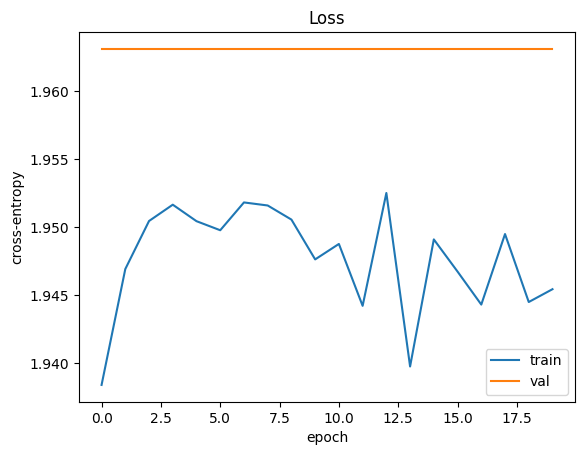

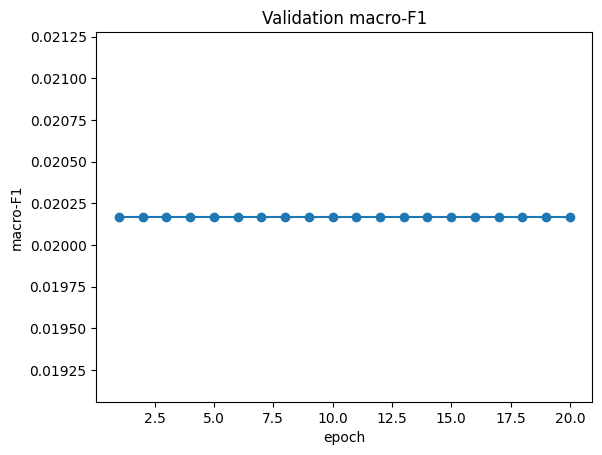

In [25]:
# ─────────────────────────────────────────────────────────────────────────────
# 0) Imports & device
# ─────────────────────────────────────────────────────────────────────────────
import os, cv2, random, math, numpy as np, pandas as pd, torch, matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision.models import alexnet
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, classification_report
torch.manual_seed(0); random.seed(0); np.random.seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ─────────────────────────────────────────────────────────────────────────────
# 1) Load CSV & keep valid clips (skip `user_00`, `unknown`, NaN)
# ─────────────────────────────────────────────────────────────────────────────
CSV = "/kaggle/working/v2e_event_labels.csv"          # ← adjust if needed
df  = (pd.read_csv(CSV)
         .dropna(subset=["label"])
         .query("label!='unknown' and user!='user_00'")
         .reset_index(drop=True))

df["avi"] = df["dvs_output_folder"].apply(
              lambda p: os.path.join(p,"dvs-video.avi"))
df["txt"] = df["avi"].str.replace(".avi","-frame_times.txt")
df = df[df.apply(lambda r: os.path.isfile(r.avi) and os.path.isfile(r.txt), axis=1)]
print(f"✔️  {len(df)} usable sessions")

labels   = sorted(df.label.unique());           NUM_CLS = len(labels)
lbl2idx  = {l:i for i,l in enumerate(labels)};  idx2lbl = {i:l for l,i in lbl2idx.items()}

# ─────────────────────────────────────────────────────────────────────────────
# 2) Dataset — uses *‑frame_times.txt*, jitter, flip
# ─────────────────────────────────────────────────────────────────────────────
# 2) Dataset with fixed‑length sampling & safe flip
class VideoEventDataset(Dataset):
    def __init__(self, df, T=32, size=128, augment=False):
        self.df, self.T, self.H, self.W, self.aug = df.reset_index(drop=True), T, size, size, augment
        self.lbl2idx = {l:i for i,l in enumerate(sorted(df.label.unique()))}

    def __len__(self): return len(self.df)

    def _frame_times(self, txt):                    # load frame timestamps
        return np.loadtxt(txt, comments='#', usecols=[1]).astype(np.float32)

    def _read_frame(self, cap, k):
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(k))
        ok,img = cap.read()
        if not ok: raise RuntimeError(f'missing frame {k}')
        g = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        g = cv2.resize(g, (self.W, self.H), interpolation=cv2.INTER_AREA)
        return g.astype(np.float32)/255.

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        ts   = self._frame_times(row.txt)
        want = np.linspace(ts[0], ts[-1], self.T, dtype=np.float32)
        fidx = np.searchsorted(ts, want).clip(0, len(ts)-1)

        if self.aug:
            fidx = (fidx + np.random.randint(-1, 2, self.T)).clip(0, len(ts)-1)

        cap = cv2.VideoCapture(row.avi)
        clip = np.stack([self._read_frame(cap, k) for k in fidx], 0)   # (T,H,W)
        cap.release()

        if self.aug and np.random.rand() < .5:               # safe horizontal flip
            clip = np.ascontiguousarray(clip[:, :, ::-1])

        clip = torch.from_numpy(clip[:, None])               # (T,1,H,W) float32
        label = self.lbl2idx[row.label]
        return clip, label

train_df,val_df=train_test_split(df,test_size=.2,stratify=df.label,random_state=1)
train_ds=VideoEventDataset(train_df,augment=True)
val_ds  =VideoEventDataset(val_df,  augment=False)

# class‑balanced sampler
freq=train_df.label.value_counts().to_dict()
weights=[1./freq[l] for l in train_df.label]
sampler=WeightedRandomSampler(weights,len(weights),replacement=True)

train_loader=DataLoader(train_ds,batch_size=8,sampler=sampler,
                        num_workers=2,pin_memory=True)
val_loader  =DataLoader(val_ds,batch_size=8,shuffle=False,
                        num_workers=2,pin_memory=True)

# ─────────────────────────────────────────────────────────────────────────────
# 3) AlexNet → LSTM model  (1‑channel input)
# ─────────────────────────────────────────────────────────────────────────────
class AlexLSTM(nn.Module):
    def __init__(self,hid=128,n_cls=NUM_CLS):
        super().__init__()
        net=alexnet(weights=None)                 # offline; no download
        net.features[0]=nn.Conv2d(1,64,11,4,2)    # 1‑ch instead of 3‑ch
        net.classifier = nn.Identity()
        with torch.no_grad(): feat=net(torch.zeros(1,1,128,128)).shape[1]
        self.cnn, self.lstm = net, nn.LSTM(feat,hid,batch_first=True)
        self.fc = nn.Linear(hid,n_cls)
    def forward(self,x):                          # x (B,T,1,H,W)
        B,T,_,H,W=x.size(); x=x.view(B*T,1,H,W)
        f=self.cnn(x).view(B,T,-1)
        h,_=self.lstm(f)
        return self.fc(h[:,-1])

model, opt = AlexLSTM().to(device), torch.optim.AdamW(AlexLSTM().parameters(),lr=3e-4)
criterion = nn.CrossEntropyLoss()

# ─────────────────────────────────────────────────────────────────────────────
# 4) Train
# ─────────────────────────────────────────────────────────────────────────────
EPOCHS=20; tr_loss=[]; va_loss=[]; va_f1=[]
for ep in range(1,EPOCHS+1):
    # train
    model.train(); s=0
    for X,y in train_loader:
        X,y=X.to(device),y.to(device)
        opt.zero_grad(); l=criterion(model(X),y); l.backward(); opt.step(); s+=l.item()
    tr_loss.append(s/len(train_loader))
    # val
    model.eval(); s=0; yt,yp=[],[]
    with torch.no_grad():
        for X,y in val_loader:
            X,y=X.to(device),y.to(device)
            out=model(X); s+=criterion(out,y).item()
            yp+=out.argmax(1).cpu().tolist(); yt+=y.cpu().tolist()
    va_loss.append(s/len(val_loader))
    _,_,f1,_=precision_recall_fscore_support(
        yt,yp,labels=list(range(NUM_CLS)),average=None,zero_division=0)
    va_f1.append(f1.mean())
    print(f"Epoch {ep:02}/{EPOCHS}  "
          f"train={tr_loss[-1]:.4f}  val={va_loss[-1]:.4f}  macro‑F1={va_f1[-1]:.3f}")

# ─────────────────────────────────────────────────────────────────────────────
# 5) Report & curves
# ─────────────────────────────────────────────────────────────────────────────
print("\n"+classification_report(
    yt,yp,target_names=[idx2lbl[i] for i in range(NUM_CLS)],zero_division=0))

plt.figure(); plt.plot(tr_loss,label='train'); plt.plot(va_loss,label='val')
plt.xlabel('epoch'); plt.ylabel('cross‑entropy'); plt.legend(); plt.title('Loss'); plt.show()

plt.figure(); plt.plot(range(1,EPOCHS+1),va_f1,marker='o')
plt.xlabel('epoch'); plt.ylabel('macro‑F1'); plt.title('Validation macro‑F1'); plt.show()
